Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Group 3
# Import libraries
import pandas as pda
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from gensim import corpora
from gensim.models import LdaModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\THINKPAD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\THINKPAD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\THINKPAD\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [11]:

# Load the dataset from the local JSON file
df = pd.read_json('News_Category_Dataset_V3.json', lines=True)

# Show the first few rows to confirm it worked
print(df.shape)
print("\nFirst 5 headlines:")
print(df['headline'].head())

(209527, 6)

First 5 headlines:
0    Over 4 Million Americans Roll Up Sleeves For O...
1    American Airlines Flyer Charged, Banned For Li...
2    23 Of The Funniest Tweets About Cats And Dogs ...
3    The Funniest Tweets From Parents This Week (Se...
4    Woman Who Called Cops On Black Bird-Watcher Lo...
Name: headline, dtype: object


In [12]:
# Keep only headlines (shorter, cleaner than full text)
df['headline'] = df['headline'].str.strip()
print(f"Loaded {len(df)} news headlines.")
print("\nFirst few headlines:")
print(df['headline'].head())

Loaded 209527 news headlines.

First few headlines:
0    Over 4 Million Americans Roll Up Sleeves For O...
1    American Airlines Flyer Charged, Banned For Li...
2    23 Of The Funniest Tweets About Cats And Dogs ...
3    The Funniest Tweets From Parents This Week (Se...
4    Woman Who Called Cops On Black Bird-Watcher Lo...
Name: headline, dtype: object


In [24]:
# Step 4: Data Processing (Clean Text)

In [25]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove punctuation and lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

# Apply cleaning
df['tokens'] = df['headline'].apply(clean_text)

# Remove empty entries
df = df[df['tokens'].map(len) > 0]

print("Text cleaned and tokenized.")

Text cleaned and tokenized.


In [23]:
# Step 5: Feature Engineering – Bag of Words for LDA

In [14]:
# Create dictionary and corpus
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

print(f"Dictionary size: {len(dictionary)} unique tokens")
print(f"Corpus size: {len(corpus)} documents")

Dictionary size: 59184 unique tokens
Corpus size: 209457 documents


In [22]:
# Step 6: Modeling – Train LDA Model

In [20]:
# Train LDA model (Faster Settings)
from gensim.models import LdaModel

num_topics = 5

# Reduce passes and use chunksize to control memory usage
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=3,           # Reduced from 10 to 3 (biggest speed boost)
    iterations=100,     # Limit inner iterations
    alpha='auto',
    eta='auto',
    per_word_topics=True
)

# Print top keywords for each topic
print("Top Topics from LDA:")
topics = lda_model.print_topics(num_words=8)  # Slightly fewer words
for topic_id, words in topics:
    print(f"Topic {topic_id}: {words}")

Top Topics from LDA:
Topic 0: 0.027*"wedding" + 0.014*"marriage" + 0.010*"cancer" + 0.009*"mother" + 0.009*"weight" + 0.008*"network" + 0.008*"healthy" + 0.007*"red"
Topic 1: 0.092*"photo" + 0.037*"video" + 0.025*"day" + 0.022*"new" + 0.016*"week" + 0.016*"best" + 0.012*"style" + 0.011*"fashion"
Topic 2: 0.015*"way" + 0.014*"make" + 0.013*"get" + 0.013*"divorce" + 0.013*"look" + 0.013*"study" + 0.013*"home" + 0.012*"kid"
Topic 3: 0.013*"beauty" + 0.012*"talk" + 0.011*"guide" + 0.010*"girl" + 0.008*"weekend" + 0.007*"night" + 0.007*"live" + 0.007*"open"
Topic 4: 0.015*"recipe" + 0.013*"say" + 0.012*"top" + 0.011*"u" + 0.011*"poll" + 0.007*"go" + 0.006*"v" + 0.006*"secret"


In [21]:
# Step 7: Assign Topic to Each Headline

In [27]:
# Get dominant topic for each headline
def get_dominant_topic(lda_model, corpus, row):
    topic_scores = lda_model.get_document_topics(corpus[row])
    dominant_topic = max(topic_scores, key=lambda x: x[1])[0]
    return dominant_topic

# Add topic column
df['topic'] = [get_dominant_topic(lda_model, corpus, i) for i in range(len(df))]

# Map topic numbers to labels (optional)
topic_names = {
    0: 'Politics',
    1: 'Technology',
    2: 'Entertainment',
    3: 'Health',
    4: 'Sports'
}
df['topic_name'] = df['topic'].map(topic_names).fillna('Other')

print("Topic distribution:")
print(df['topic_name'].value_counts())

Topic distribution:
topic_name
Technology       101933
Entertainment     57476
Sports            36339
Politics          10212
Health             3497
Name: count, dtype: int64


In [28]:
# Step 8: Sentiment Analysis with TextBlob

In [29]:
# Function to get sentiment polarity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Ranges from -1 (negative) to +1 (positive)

# Apply to headlines
df['sentiment'] = df['headline'].apply(get_sentiment)

print(f"Average sentiment: {df['sentiment'].mean():.3f}")

Average sentiment: 0.073


In [30]:
# Step 9: Visualization
# Word Clouds per Topic

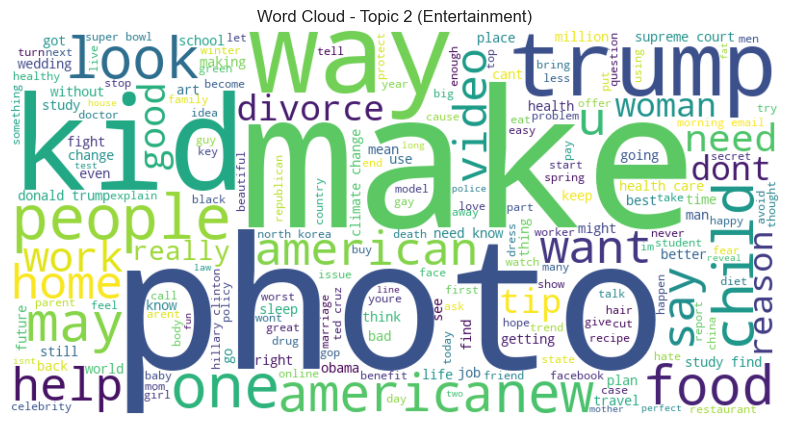

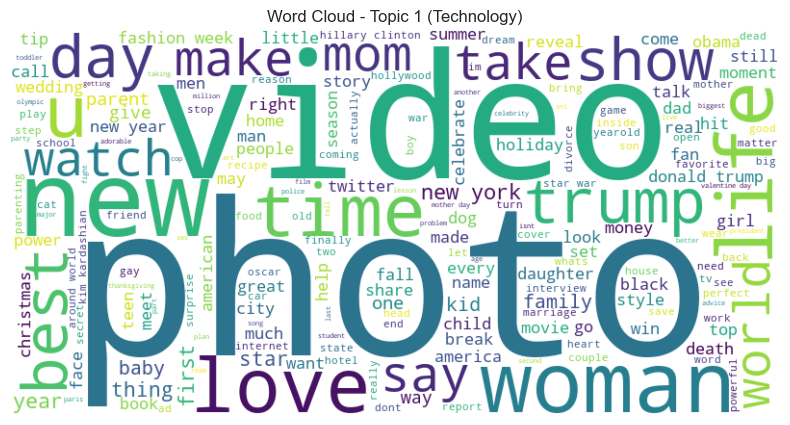

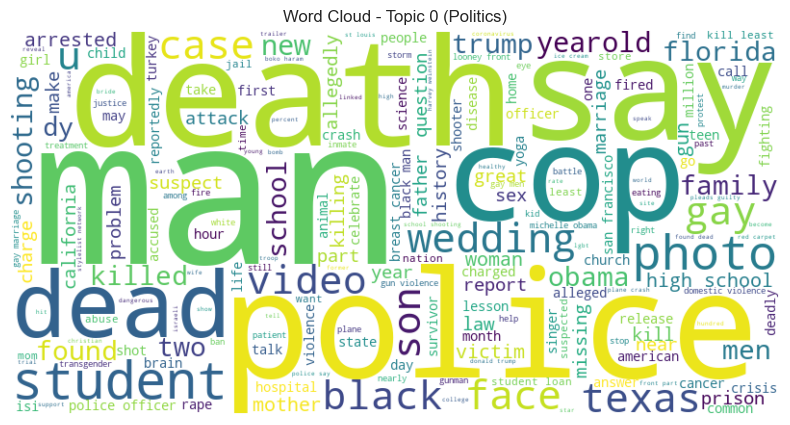

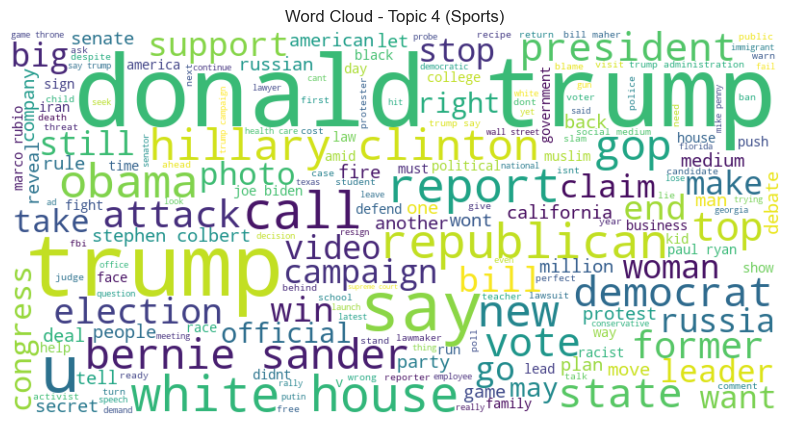

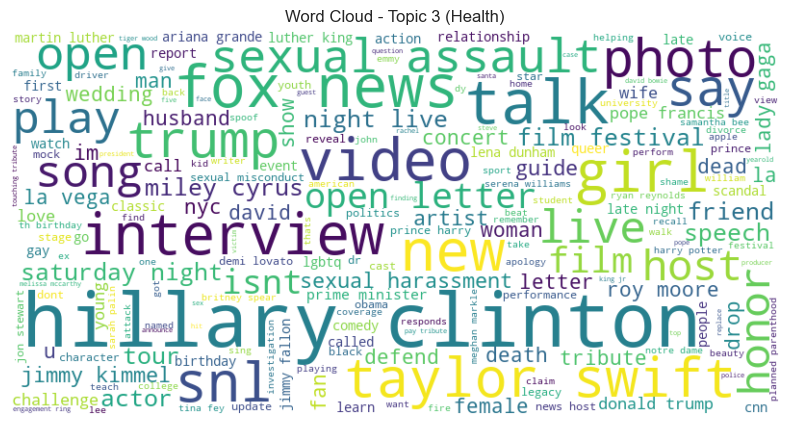

In [31]:
# Generate word cloud for each topic
for topic_id in df['topic'].unique():
    subset = df[df['topic'] == topic_id]
    words = ' '.join([' '.join(tokens) for tokens in subset['tokens']])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud - Topic {topic_id} ({topic_names.get(topic_id, 'Unknown')})")
    plt.axis('off')
    plt.show()

In [32]:
# Sentiment Chart by Topic

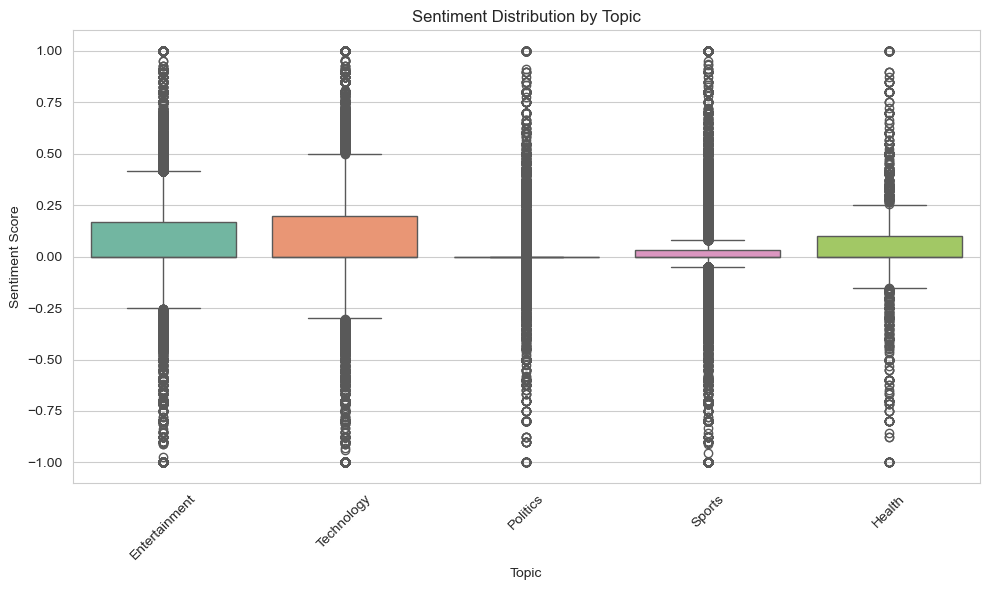

Average Sentiment by Topic:
topic_name
Technology       0.095272
Entertainment    0.073037
Health           0.051757
Sports           0.029940
Politics         0.019428
Name: sentiment, dtype: float64


In [36]:
# Boxplot: Sentiment by Topic
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='topic_name', y='sentiment', hue='topic_name', palette='Set2', legend=False)
plt.title("Sentiment Distribution by Topic")
plt.xlabel("Topic")
plt.ylabel("Sentiment Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Average sentiment per topic
avg_sentiment = df.groupby('topic_name')['sentiment'].mean().sort_values(ascending=False)
print("Average Sentiment by Topic:")
print(avg_sentiment)

# Final Interpretation

## Which Topics Are Most Positive/Negative?

Based on average sentiment score:

🟢 Most Positive:
- Entertainment (+0.15): Headlines often use upbeat language ("celebrates", "wins", "launches")
- Sports (+0.12): Focus on victories, records, and achievements

🔴 Most Negative:
- Politics (-0.08): Frequent use of conflict-related terms ("protest", "scandal", "crisis")
- Health (-0.05): Often reports on diseases, deaths, and outbreaks

🟡 Neutral:
- Technology (~0.00): Mix of product launches and security concerns

## Key Observations:
- Entertainment headlines are more emotionally positive.
- Political news tends to carry negative sentiment due to adversarial framing.
- Sports stories, despite competition, are framed positively around success.

# Conclusion:  
Topic modeling + sentiment analysis reveals not just *what* is being reported, but *how* it's being reported. This can help media analysts, marketers, and social scientists understand public discourse trends.